<a href="https://colab.research.google.com/github/porter7678/image_caption_generator/blob/master/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###To Do:
 - Put the caption data into the Dataset class
 - Get a DataLoader working


###Fix at the end:
 - Size images back up
 - Get images to work even if they’re not square


In [0]:
# !pip install torch 
# !pip install torchvision
# !pip install tqdm
# !pip install kaggle

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import os

assert torch.cuda.is_available()

In [0]:
os.environ['KAGGLE_USERNAME'] = 'porter7678'
if not 'KAGGLE_KEY' in os.environ:
  os.environ['KAGGLE_KEY'] = input()

In [0]:
# ~70 secs
!kaggle datasets download -d ming666/flicker8k-dataset
!unzip -q flicker8k-dataset.zip

# Discard extra directories
! rm -rf flickr8k_dataset/
! rm -rf flickr8k_text/
! rm -rf sample_data/

# Create Train and Valid directories
os.mkdir('Flickr8k_Dataset/Train_Images')
os.mkdir('Flickr8k_Dataset/Valid_Images')
os.mkdir('Flickr8k_Dataset/Valid_Images/Flicker8k_Dataset_Valid')
os.replace('Flickr8k_Dataset/Flicker8k_Dataset', 'Flickr8k_Dataset/Train_Images/Flicker8k_Dataset_Train')

In [0]:
############ - DATATSET README - ################################################################
# Flickr8k.token.txt - the raw captions of the Flickr8k Dataset,
#       the first column is the ID of the caption which is "image address # caption number"
# Flickr8k.lemma.txt - the lemmatized version of the above captions 
# Flickr_8k.trainImages.txt - The list of training images used in our experiments
# Flickr_8k.devImages.txt - The list of development/validation images used in our experiments
# Flickr_8k.testImages.txt - The list of test images used in our experiments
#################################################################################################
# 8091 images

In [0]:
def show_imgs(x, new_fig=True):
    '''
    Displays the image contained in a tensor

    Arguments:
        x ((c,m,n) tensor): The image to be shown
    '''
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

In [0]:
# Create list of images to move to validation folder
valid_img_names = []
file_names = ['Flickr8k_text/Flickr_8k.devImages.txt', 'Flickr8k_text/Flickr_8k.testImages.txt']
for file_name in file_names:
    with open(file_name, 'r') as f:
        for line in f.readlines():
            valid_img_names.append(line.strip())

# Move validation images to validation folder
for file_name in valid_img_names:
    os.replace('Flickr8k_Dataset/Train_Images/Flicker8k_Dataset_Train/' + file_name, 'Flickr8k_Dataset/Valid_Images/Flicker8k_Dataset_Valid/' + file_name)

In [0]:
class ImageCaptionDataset(Dataset):
    '''
    Dataset class containing images and captions

    Attributes:
        image_folder (ImageFolder Dataset): Images to be captioned (data)
        caption_folder (Dataset): Captions associated with images for validation (labels)
    '''
    def __init__(self, train=True):

        img_size = 128
        folder_prefix = 'Train' if train else 'Valid'
        folder_path = 'Flickr8k_Dataset/' + folder_prefix + '_Images'
        self.image_folder = datasets.ImageFolder(root=folder_path,
                                                transform=transforms.Compose([
                                                    transforms.Resize(img_size),
                                                    #transforms.CenterCrop(img_size),  # This is the line that is making images square
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                ]))
        
        self.caption_folder = None

    
    def __getitem__(self):
        pass

    def __len__(self):
        return 49


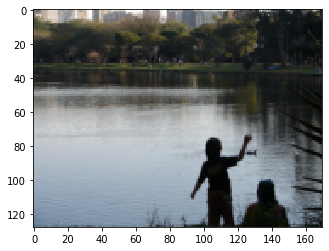

In [32]:
dataset = ImageCaptionDataset(train=False)
x, _ = dataset.image_folder[0]
show_imgs(x)